# Определение стоимости автомобиля

**Описание проекта:** нужно построить модель для определения стоимости автомобиля по историческим данным (технические характеристики, комплектации и цены автомобилей).

# 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
import lightgbm as lgbm

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

np.set_printoptions(suppress=True)

In [2]:
autos = pd.read_csv("/datasets/autos.csv")

In [3]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [4]:
autos

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


Всего в датасете 354 369 объектов, каждый из которых соответствует одной анкете, и 16 признаков. Часть признаков вряд ли имеют предсказательную ценность в модели, однако могут пригодиться на этапе исследования данных:
- **DateCrawled** (дата выгрузки объявления) может использоваться для выявления проблем с выгрузкой и объяснения пропусков, ошибок в данных;
- **RegistrationMonth** (месяц регистрации автомобиля) в данном исследовании не пригодится, поэтому исключим его из датасета;
- **DateCreated** (дата создания анкеты) и **LastSeen** (дата последней активности пользователя) могут подсказать как долго продавалась машина, однако в данном исследовании не имеют значения;
- **PostalCode** (почтовый индекс пользователя) может быть использован для определения города, однако для использования в модели требует преобразований в категориальный признак (названия городов возможно придется подтягивать по api). 

Удалим перечисленные признаки из датасета после проведения исследования.

Среди признаков есть как числовые, так и категориальные. Категориальные признаки необходимо преобразовать. Для ```LinearRegression``` подойдет метод "one hot encoding". ```LightGBM```и ```RandomForestRegressor``` работают с категориальными признаками напрямую если категории представлены числами, поэтому перед обучением применим метод порядкового кодирования ("ordinal encoder") и изменим типы данных. 

Значения числовых признаков будут стандартизированны при подготовке выборок. Преобразование типов необходимо только для дат.

In [5]:
# преобразуем типы данных
autos['DateCrawled'] = pd.to_datetime(autos['DateCrawled'])
autos['DateCreated'] = pd.to_datetime(autos['DateCreated'])
autos['LastSeen'] = pd.to_datetime(autos['LastSeen'])

Исследуем дескриптивные статистики на предмет ошибочных значений и для общего ознакомления с данными.

In [6]:
autos.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


### Price
По таблице с описательными статистиками, а именно межквартильному размаху, можно заключить что большинство продаваемых на платформе автомобилей имеют стоимость от 1050 до 6400 евро. Медиана располагается левее среднего (разница почти 1700 евро), что говорит о правосторонней асимметрии, распределение визуально напоминает логонормальное. Данный признак является целевым, поэтому его распределение наиболее важно для подбора модели регрессии. Логонормальное распределение означает, что логарифм значений признака распределен нормально т.е. можно сказать что это вариант нормального распределения. Можно преобразовать логонормальное распределение в нормальное, но, на сколько понимаю, в данном случае это не обязательно.

In [7]:
def group_hist_boxplot(data, color):
    fig = plt.figure(figsize=(10, 5))
    gs = fig.add_gridspec(3, 1)
    ax = fig.add_subplot(gs[:2, 0])
    ax.set_ylabel('Частота', fontsize=12)
    sns.distplot(data, ax=ax, color=color, kde=False)
    ax2 = fig.add_subplot(gs[2, 0])
    sns.boxplot(data, ax=ax2, width=0.5, color=color)
    fig.tight_layout()
    return ax

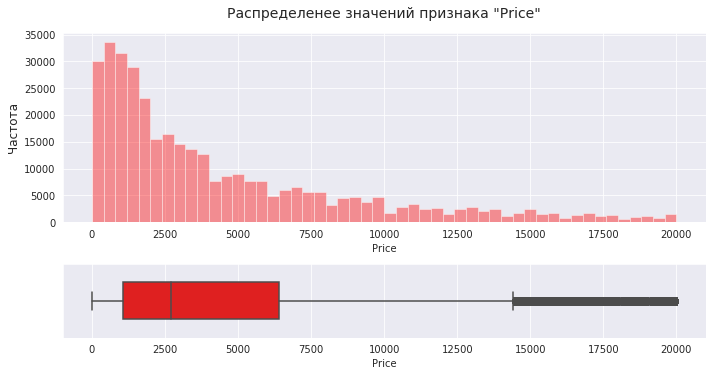

In [8]:
with sns.axes_style("darkgrid"):
    ax = group_hist_boxplot(autos['Price'], "red")
    ax.set_title('Распределенее значений признака "Price"', size=14, pad=15)

plt.show()

Есть объекты стоимостью 0 евро, что является невозможным (ошибочным) или может быть интерпретировано как пропущенное значение. Так как данный признак является целевым, пропуски в нем недопустимы. Цены ниже 50 евро в Европе гипотетически возможны для старых машин, так как у них высокие налоги на выработку CO2 и дорогая утилизация (поэтому они могут стремиться скорее избавиться от такого автомобиля). Из-за этого, в некоторых случаях, рыночная стоимость может быть специфичной — то что в Европе может стоить 50 евро в России может стоить до 1 тыс. евро (или в каких-нибудь развивающихся странах, где не особо озабочены экологией).

In [9]:
# удалим нули в целевом признаке
print("Кол-во объектов до удаления:", autos.shape[0])
autos = autos.drop(autos[autos['Price'] == 0].index
                  ).reset_index(drop=True)
print("Кол-во объектов после удаления:", autos.shape[0])

Кол-во объектов до удаления: 354369
Кол-во объектов после удаления: 343597


### RegistrationYear
Чаще всего пользователи продают автомобили 1999-2008 гг. Подозрительно выглядит стандартное отклонение в 90 лет, наличие автомобилей 1000 и 9999 годов. Данные значения являются невозможными (ошибочными).

Обычно на стоимость автомобилей влияет время эксплуатации. Это подтверждается жизненным опытом — новые автомобили чаще стоят дороже, а старые (не коллекционные) дешевле. Год регистрации также влияет и на другие признаки. Например, мощность двигателя, тип коробки передач или потребляемого топлива. Получается, что данные не являются полностью независимыми, имеет место автокорреляция (?).

Рассмотрим как изменяется стоимость автомобилей в зависимости от года его регистрации.

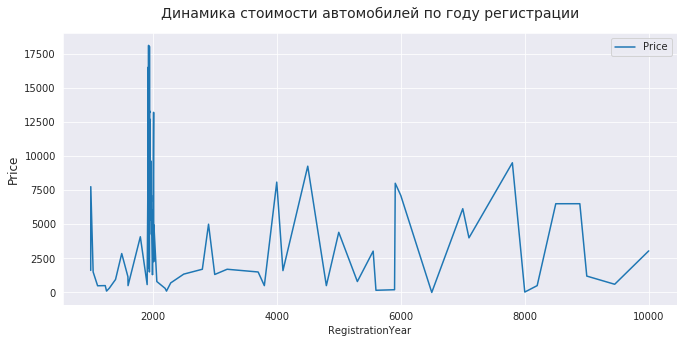

In [10]:
with sns.axes_style("darkgrid"):
    fig = plt.figure(figsize=(11, 5))
    ax = sns.lineplot(data=autos.pivot_table(
        index='RegistrationYear', values='Price', aggfunc="mean"))
    ax.set_title('Динамика стоимости автомобилей по году регистрации', size=14, pad=15)
    ax.set_ylabel('Price', fontsize=12)

По диаграмме видно, что в признаке **RegistrationYear** большое количество некорректных данных которые необходимо исключить их из датасета. Нижнюю границу, предварительно, установим в районе 1980 года, а верхнюю определим по году создания объявления (автомобиль не может быть зарегистрирован позже, чем размещено объявление).

In [11]:
# удалим объекты в которых год регистрации ниже 1980 или больше года публикации объявления
print("Кол-во объектов до удаления:", autos.shape[0])
autos = autos.drop(autos[(autos['RegistrationYear'] < 1980) |
                         (autos['RegistrationYear'] > 
                          autos['DateCreated'].dt.year)].index
                  ).reset_index(drop=True)
print("Кол-во объектов после удаления:", autos.shape[0])

Кол-во объектов до удаления: 343597
Кол-во объектов после удаления: 326652


Повторно рассмотрим динамику стоимости автомобилей по году регистрации.

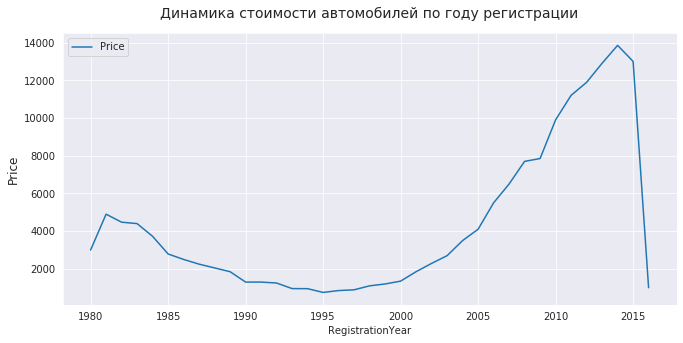

In [12]:
with sns.axes_style("darkgrid"):
    fig = plt.figure(figsize=(11, 5))
    ax = sns.lineplot(data=autos.pivot_table(
        index='RegistrationYear', values='Price', aggfunc="median"))
    ax.set_title('Динамика стоимости автомобилей по году регистрации', size=14, pad=15)
    ax.set_ylabel('Price', fontsize=12)

Теперь данные выглядят реалистичнее, хотя "холм" в период 1980-1995 гг выглядит странно. Рассмотрим распределение при помощи гистограммы и "ящика с усами".  

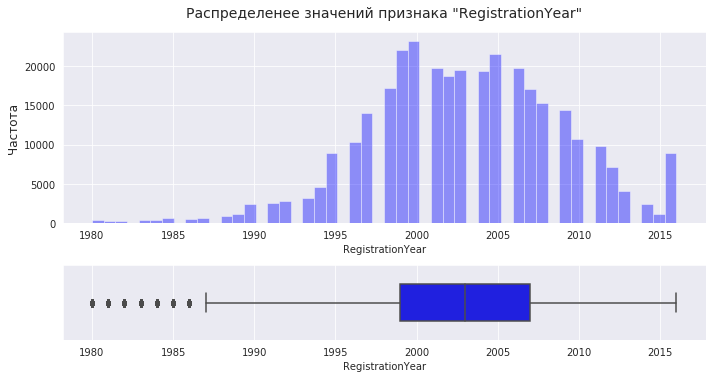

In [13]:
with sns.axes_style("darkgrid"):
    ax = group_hist_boxplot(autos['RegistrationYear'], "blue")
    ax.set_title('Распределенее значений признака "RegistrationYear"', size=14, pad=15)

plt.show()

### Power
В среднем мощность продаваемых авто составляет 110 л.с (лошадиных сил). Встречаются невозможные (ошибочные значения): есть автомобили с мощностью двигателя 0 и 20 000 л.с. Нули могут означать пропуски. Максимальный порог установим в 500 л.с., свыше уже идут суперкары, которые вряд ли будут стоить 20 тыс. евро (даже будучи в прошлом битыми). Минимальный порог установить сложнее, так как машины мощностью до 50 л.с. это либо электрокары, либо коллекционные ретро автомобили (которые, скорее всего, также будут стоить дороже 20 тыс. евро). Необходимо учесть это в фильтре.

In [14]:
# удалим объекты в которых мощность меньше 39 л.с. или выше 500 л.с.
print("Кол-во объектов до удаления:", autos.shape[0])
autos = autos.drop(autos[(autos['Power'] > 500) |
                         (autos['Power'] == 0) |
                         (autos['Power'] < 39) & 
                         ~(autos['FuelType'] == 'electric')].index
                  ).reset_index(drop=True)
print("Кол-во объектов после удаления:", autos.shape[0])

Кол-во объектов до удаления: 326652
Кол-во объектов после удаления: 293492


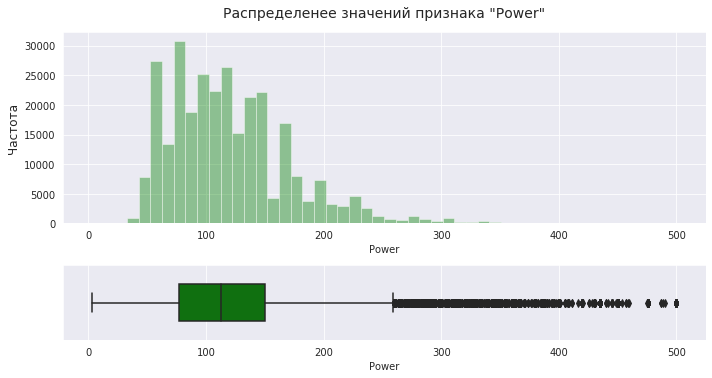

In [15]:
with sns.axes_style("darkgrid"):
    ax = group_hist_boxplot(autos['Power'], "green")
    ax.set_title('Распределенее значений признака "Power"', size=14, pad=15)

plt.show()

### Kilometer
Более половины автомобилей имеют пробег 150 000. Это может быть объяснено тем, что в анкете это поле пользователи вводили не самостоятельно, а выбирали варианты из выпадающего списка (например). Вариант 150 000 был максимальным возможным в этом списке.

### RegistrationMonth
Месяц регистрации автомобиля в данном исследовании нам не понадобится, так как не имеет никакой связи со стоимостью. Данный признак будет удален.

### NumberOfPictures
Количество фотографий автомобиля в каждой из анкет равно нулю. Данный признак не представляет интереса для дальнейшего моделирования, поэтому он будет исключен из датасета.

### PostalCode
Почтовый индекс пользователя сам по себе не может быть использован в модели, так как будет воспринят ей как числовой признак. После проверки индексов было выяснено, что один и тот же индекс может принадлежать разным городам и странам, поэтому по нему не получится выяснить точную локацию. Данный признак будет исключен из датасета.

Теперь исследуем категориальные признаки.

In [16]:
def plotting_bars(data, index, color):
    ptable = pd.DataFrame(data.pivot_table(index=index, aggfunc="size"
                                          ).sort_values(ascending=False)
                         ).head(10)
    ptable.columns = ['count']
    with sns.axes_style("darkgrid"):
        sns.barplot(x='count', y=ptable.index, color=color,
                    alpha=.5, data=ptable)

### VehicleType

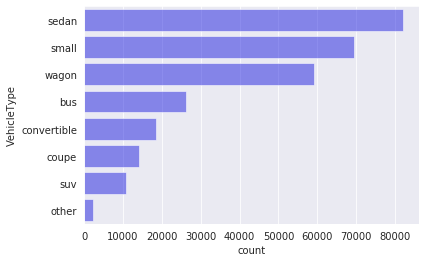

In [17]:
plotting_bars(autos, 'VehicleType', 'blue')

Среди всех представленных на платформе автомобилей наиболее популярными являются седаны, xэтчбеки (возможно small) и универсалы. Всего данный признак объединяет восемь классов.

### Gearbox

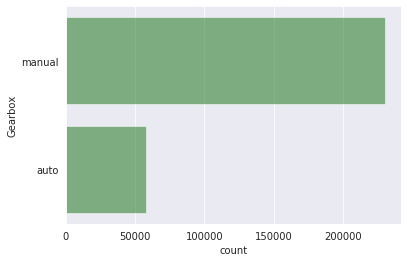

In [18]:
plotting_bars(autos, 'Gearbox', 'green')

Всего два варианта коробки передач — автоматическая и механическая.

### FuelType

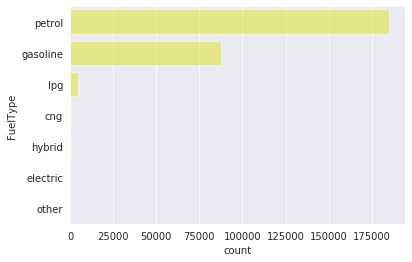

In [19]:
plotting_bars(autos, 'FuelType', 'yellow')

В данной категории семь классов. Наиболее популярными являются "petrol" и "gasoline", что в сущности означает одно и тоже — бензин. Первое название чаще используется в Европе, а второе в США и Канаде. Это может означать, что на платформе представлены автомобили из разных регионов, а значит цены на одни и те же автомобили могут заметно отличаться. По этой причине данные категории не будут объединяться в одну.

### Brand & Model

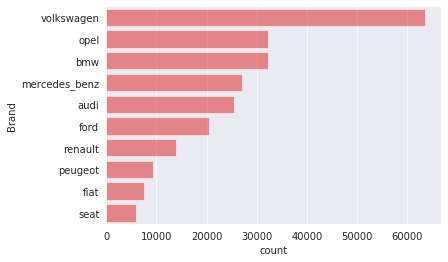

In [20]:
plotting_bars(autos, 'Brand', 'red')

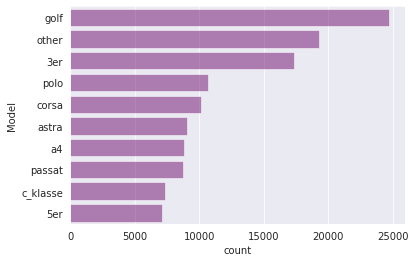

In [21]:
plotting_bars(autos, 'Model', 'purple')

По данным анкет получилось 40 уникальных брендов и 248 моделей. На диаграмме представлено десять наиболее популярных. Первое место, с большим отрывом, занимает 'volkswagen golf'.

### NotRepaired

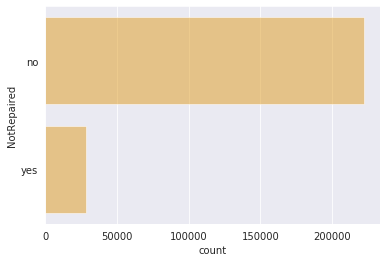

In [22]:
plotting_bars(autos, 'NotRepaired', 'orange')

Только малая часть пользователей указали, что их автомобиль был в ремонте.

### Анализ пропущенных значений
В данных имеются пропущенные значения. Посчитаем их, попытаемся объяснить их природу (случайные/неслучайные), возможные причины, а также определим способы заполнения пропусков.

In [23]:
def na_info(data):
    result = pd.DataFrame(columns=['column_with_na', 'count_na', 'part_of_total']) 
    
    for column in data.columns:
        if data[column].isna().sum() > 0:
            result = result.append({'column_with_na': column,
                                    'count_na': data[column].isna().sum(),
                                    'part_of_total': (data[column].isna().sum()
                                                      / data.shape[0])
                                   }, ignore_index=True) 

    result.index = range(1, len(result['column_with_na']) + 1)
    result = result.style.format({'part_of_total': "{:.2%}"})

    return result

In [24]:
na_info(autos)

,column_with_na,count_na,part_of_total
1,VehicleType,10915,3.72%
2,Gearbox,5230,1.78%
3,Model,10534,3.59%
4,FuelType,15314,5.22%
5,NotRepaired,42308,14.42%


Пропущенные значения есть в пяти категориальных признаках.

Больше всего пропусков (14% от общей выборки) содержится в признаке **NotRepaired**. Пропуски по данному полю скорее всего неслучайные — пользователи могли сознательно опустить данный факт из страха, что им будет сложнее продать машину. Исходя из этого предполагаю, что пропуск скорее означает "yes", чем "no". Остальные пропуски связаны с модельными характеристиками автомобиля — название модели, тип кузова, тип топлива и тип коробки передач. Если в первом случае мы можем решить проблему создав еще одну категорию, то во втором случае категорий гораздо больше и точно восстановить их проблематично. Возможно правильнее будет попросту исключить их из датасета или заменить модами.

### Предобработка

In [25]:
# создадим еще одну категорию для пропущенных значений
autos['NotRepaired'].fillna("not_specified", inplace=True)

In [26]:
# заменим модами пропуски в остальных признаках
autos['VehicleType'].fillna(autos['VehicleType'].mode()[0], inplace=True)
autos['Gearbox'].fillna(autos['Gearbox'].mode()[0], inplace=True)
autos['Model'].fillna(autos['Model'].mode()[0], inplace=True)
autos['FuelType'].fillna(autos['FuelType'].mode()[0], inplace=True)

Проверим есть ли полные дубликаты строк (объектов) и при необходимости избавимся от них.

In [27]:
print(f"Количество полных дубликатов строк: {autos.duplicated().sum()}")

Количество полных дубликатов строк: 4


In [28]:
# удалим полные дубликаты строк
autos = autos.drop_duplicates().reset_index(drop=True)

Исключим из датасетов неинформативные признаки.

In [29]:
autos = autos.drop(columns=['DateCrawled', 'RegistrationMonth', 'DateCreated',
                            'LastSeen', 'PostalCode', 'NumberOfPictures'])

Закодируем категориальные признаки двумя способами — методом прямого кодирования для линейной регрессии и методом порядкового кодирования для остальных сравниваемых моделей.

In [30]:
autos_oe = pd.DataFrame.copy(autos)

In [31]:
category = autos.select_dtypes("object").columns

In [32]:
# порядковое кодирование
for col in category:
    autos_oe[col] = OrdinalEncoder(dtype=int).fit_transform(autos_oe[[col]])

In [33]:
autos_oe.loc[:, category] = autos_oe.loc[:, category].astype("category")

In [34]:
# прямое кодирование
autos_ohe = pd.get_dummies(autos, drop_first=True)

Разобьём полученные выборки на три части — обучающую, валидационную и тестовую выборку. Таким образом получим выборки объемом 60-20-20.

In [35]:
# функция для получения стандартизированных выборок
def sampling(data, target_name):
    target = data[target_name]
    features = data.drop(target_name, axis=1)
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.40, random_state=123)
    features_valid, features_test, target_valid, target_test = train_test_split(
        features_valid, target_valid, test_size=0.50, random_state=123)
    scaler = StandardScaler()
    numeric_columns = features.select_dtypes(include="number").columns
    scaler.fit(features_train.loc[:, numeric_columns])
    features_train.loc[:, numeric_columns] = scaler.transform(
        features_train.loc[:, numeric_columns])
    features_valid.loc[:, numeric_columns] = scaler.transform(
        features_valid.loc[:, numeric_columns])
    features_test.loc[:, numeric_columns] = scaler.transform(
        features_test.loc[:, numeric_columns])
    return (features_train, features_valid, features_test,
            target_train, target_valid, target_test)

In [36]:
(features_train, features_valid, features_test, 
 target_train, target_valid, target_test) = (sampling(autos_ohe, 'Price'))

In [37]:
(features_train_encode, features_valid_encode, features_test_encode, 
 target_train_encode, target_valid_encode, target_test_encode) = (sampling(autos_oe, 'Price'))

# 2. Обучение моделей

### RandomForestRegressor

In [38]:
def rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return mse ** 0.5

Подберем гиперпараметры.

In [39]:
n_estimators = [int(x) for x in np.linspace(start=100, stop=200, num=3)]
max_depth = [int(x) for x in np.linspace(start=5, stop=15, num=3)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

scorer = {'rmse': make_scorer(rmse, greater_is_better=False)}

print(random_grid)

{'n_estimators': [100, 150, 200], 'max_depth': [5, 10, 15], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [40]:
rf_test = RandomForestRegressor(random_state=123)

In [41]:
rf_random = RandomizedSearchCV(estimator=rf_test, scoring=scorer,
    param_distributions=random_grid, verbose=2, refit="rmse",
    random_state=123, n_jobs=-1)

rf_random.fit(features_train_encode, target_train_encode)

In [42]:
rf_best_params = {
    'n_estimators': 200,
    'min_samples_split': 2,
    'min_samples_leaf': 2,
    'max_depth': 15,
    'bootstrap': True}

rf_best_params

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_depth': 15,
 'bootstrap': True}

Обучим модель на выборке закодированной по методу порядково кодирования, так как это значительно ускорит процесс обучения (вычислительная сложность сильно зависит от количества признаков).

In [43]:
rf = RandomForestRegressor(random_state=321, **rf_best_params)

In [44]:
%%time
rf.fit(features_train_encode, target_train_encode)

CPU times: user 1min 13s, sys: 232 ms, total: 1min 14s
Wall time: 1min 14s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=321, verbose=0,
                      warm_start=False)

In [45]:
%%time
rf_pred = rf.predict(features_train_encode)

CPU times: user 7.85 s, sys: 23.2 ms, total: 7.87 s
Wall time: 7.99 s


In [46]:
%%time
rf_pred_valid = rf.predict(features_valid_encode)

CPU times: user 2.69 s, sys: 7.84 ms, total: 2.7 s
Wall time: 2.71 s


In [47]:
print("RMSE на обучающей выборке: ", rmse(target_train_encode, rf_pred))
print("RMSE на валидационной выборке: ", rmse(target_valid_encode, rf_pred_valid))

RMSE на обучающей выборке:  1288.7821404284462
RMSE на валидационной выборке:  1580.5364501506783


Модель регрессора случайного леса обучилась за 1 минуту 14 секунд. RMSE на обучающей выборке составил 1288 евро, а на валидационной 1580 евро. Разница в 300 евро может означать, что модель немного переобучилась. 

### LinearRegression

In [48]:
%%time
lm = LinearRegression().fit(features_train, target_train)

CPU times: user 13.5 s, sys: 5.65 s, total: 19.2 s
Wall time: 19.4 s


In [49]:
%%time
lm_pred = lm.predict(features_train)

CPU times: user 158 ms, sys: 28 ms, total: 186 ms
Wall time: 198 ms


In [50]:
%%time
lm_pred_valid = lm.predict(features_valid)

CPU times: user 137 ms, sys: 53.5 ms, total: 190 ms
Wall time: 233 ms


In [51]:
print("RMSE на обучающей выборке: ", rmse(target_train, lm_pred))
print("RMSE на валидационной выборке: ", rmse(target_valid, lm_pred_valid))

RMSE на обучающей выборке:  2452.3523951257816
RMSE на валидационной выборке:  2441.4686601753074


Линейная регрессия обучалась около 20 секунд, но качество предсказаний по RMSE составило - 2452 на обучающей выборке и 2441 на валидационной. Либо модель недообучилась, что возможно если ей помешали "выбросы" так как обучающая выборка велика, либо данные не могут быть аппроксимированы простой линейной функцией и модель необходимо усложнить.

Попробуем усложнить модель, но предварительно сократим количество признаков.

In [52]:
autos_ohe_ = pd.get_dummies(autos.drop(
    ['Model', 'Brand', 'VehicleType', 'FuelType'], axis=1), drop_first=True)

In [53]:
(features_train_, features_valid_, features_test_, 
 target_train_, target_valid_, target_test_) = (sampling(autos_ohe_, 'Price'))

In [54]:
polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=5, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

In [55]:
%%time
polynomial_regression.fit(features_train_, target_train_)

CPU times: user 26 s, sys: 12.1 s, total: 38.1 s
Wall time: 38.2 s


Pipeline(memory=None,
         steps=[('poly_features',
                 PolynomialFeatures(degree=5, include_bias=False,
                                    interaction_only=False, order='C')),
                ('lin_reg',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [56]:
%%time
lm_pred_ = polynomial_regression.predict(features_train_)

CPU times: user 2.6 s, sys: 215 ms, total: 2.81 s
Wall time: 3.29 s


In [57]:
%%time
lm_pred_valid_ = polynomial_regression.predict(features_valid_)

CPU times: user 616 ms, sys: 57.2 ms, total: 674 ms
Wall time: 719 ms


In [58]:
print("RMSE на обучающей выборке: ", rmse(target_train_, lm_pred_))
print("RMSE на валидационной выборке: ", rmse(target_valid_, lm_pred_valid_))

RMSE на обучающей выборке:  2091.419778918672
RMSE на валидационной выборке:  2096.570744127404


После полиномизации признаков модель стала обучаться немного дольше (около 30 секунд), ее качество улучшилось. При увеличении максимальной степени на единицу RMSE уменьшается примерно на 100 евро, поэтому дальнейшее увеличение степени скорее всего невозможно и нецелесообразно, т.к. может привести к переобучению. Можно улучшить данный результат, если провести более строгую предобработку данных.

### SGDRegressor

От этой модели нет особых ожиданий, так как она может улучшить результат если простая линейная модель переобучается. Однако все же интересно посмотреть на результат работы ```RandomizedSearchCV```.

In [59]:
loss = ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']
penalty = ['l2', 'l1', 'elasticnet']
alpha = [0.0001, 0.005, 0.01]
l1_ratio = [0.0, 0.15, 0.3]
max_iter = [1000, 3000, 5000]
fit_intercept = [True, False]
shuffle = [True, False]
learning_rate = ['optimal', 'invscaling', 'adaptive']

sgdr_grid = {'loss': loss,
             'penalty': penalty,
             'alpha': alpha,
             'l1_ratio': l1_ratio,
             'max_iter': max_iter,
             'fit_intercept': fit_intercept,
             'shuffle': shuffle,
             'learning_rate': learning_rate
            }

print(sgdr_grid)

{'loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'], 'penalty': ['l2', 'l1', 'elasticnet'], 'alpha': [0.0001, 0.005, 0.01], 'l1_ratio': [0.0, 0.15, 0.3], 'max_iter': [1000, 3000, 5000], 'fit_intercept': [True, False], 'shuffle': [True, False], 'learning_rate': ['optimal', 'invscaling', 'adaptive']}


In [60]:
poly_train = PolynomialFeatures(degree=5, include_bias=False).fit_transform(features_train_)

In [61]:
poly_valid = PolynomialFeatures(degree=5, include_bias=False).fit_transform(features_valid_)

In [62]:
sgdr = SGDRegressor()

In [63]:
sgdr_random = RandomizedSearchCV(estimator=sgdr, scoring=scorer,
    param_distributions=sgdr_grid, verbose=2, refit="rmse",
    random_state=456, n_jobs=-1)

sgdr_random.fit(poly_train, target_train_)

In [64]:
sgdr_best_params = {
    'shuffle': False,
    'penalty': 'l2',
    'max_iter': 1000,
    'loss': 'epsilon_insensitive',
    'learning_rate': 'adaptive',
    'l1_ratio': 0.3,
    'fit_intercept': True,
    'alpha': 0.0001
}

In [65]:
sgd_reg = SGDRegressor(**sgdr_best_params)

In [66]:
%%time
sgd_reg.fit(poly_train, target_train_)

CPU times: user 51.9 s, sys: 0 ns, total: 51.9 s
Wall time: 52.5 s


SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.3,
             learning_rate='adaptive', loss='epsilon_insensitive',
             max_iter=1000, n_iter_no_change=5, penalty='l2', power_t=0.25,
             random_state=None, shuffle=False, tol=0.001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [67]:
%%time
sgdr_pred = sgd_reg.predict(poly_train)

CPU times: user 234 ms, sys: 0 ns, total: 234 ms
Wall time: 215 ms


In [68]:
%%time
sgdr_pred_valid = sgd_reg.predict(poly_valid)

CPU times: user 133 ms, sys: 0 ns, total: 133 ms
Wall time: 113 ms


In [69]:
print("RMSE на обучающей выборке: ", rmse(target_train_, sgdr_pred))
print("RMSE на валидационной выборке: ", rmse(target_valid_, sgdr_pred_valid))

RMSE на обучающей выборке:  2407.7388857816522
RMSE на валидационной выборке:  2388.909246381319


Модель обучалась около 50 секунд. RMSE на обучающей выборке выше чем на валидационной (может быть из-за выбросов). Полагаю, модель недообучилась и регуляризация не нужна, но модель с коэф. регуляризации отличным от нуля оказалась лучшей, чем без регуляризации (по ```RandomizedSearchCV```). Возможно повлияли другие гиперпараметры.

### LightGBM

In [70]:
boosting_type = ['gbdt', 'dart']
max_depth = [int(x) for x in np.linspace(start=5, stop=15, num=3)]
num_leaves = [int(x) for x in np.linspace(start=30, stop=800, num=4)]
min_data_in_leaf = [int(x) for x in np.linspace(start=100, stop=1000, num=3)]
metric = "rmse"
max_bin = [255, 500]
num_iterations = [100, 300, 500]

lgbmr_grid = {'boosting_type': boosting_type,
             'max_depth': max_depth,
             'num_leaves': num_leaves,
             'min_data_in_leaf': min_data_in_leaf,
             'metric': metric,
             'max_bin': max_bin,
             'num_iterations': num_iterations
            }

print(lgbmr_grid)

{'boosting_type': ['gbdt', 'dart'], 'max_depth': [5, 10, 15], 'num_leaves': [30, 286, 543, 800], 'min_data_in_leaf': [100, 550, 1000], 'metric': 'rmse', 'max_bin': [255, 500], 'num_iterations': [100, 300, 500]}


In [71]:
lgbmr = lgbm.LGBMRegressor()

In [72]:
lgbmr_random = RandomizedSearchCV(estimator=lgbmr, scoring=scorer,
    param_distributions=lgbmr_grid, verbose=2, refit="rmse",
    random_state=789, n_jobs=-1)

lgbmr_random.fit(features_train_encode, target_train_encode)

In [73]:
lgbmr_best_params = {
    'num_leaves': 700,
    'num_iterations': 700,
    'min_data_in_leaf': 100,
    'metric': 'rmse',
    'max_depth': 15,
    'max_bin': 255,
    'boosting_type': "gbdt",
    'tree_learner_type': "data",
}

In [74]:
lgbm_reg = lgbm.LGBMRegressor(**lgbmr_best_params)

lgbm_reg

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_bin=255,
              max_depth=15, metric='rmse', min_child_samples=20,
              min_child_weight=0.001, min_data_in_leaf=100, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_iterations=700, num_leaves=700,
              objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0, tree_learner_type='data')

In [75]:
%%time
lgbm_reg.fit(features_train_encode, target_train_encode)

CPU times: user 1min 3s, sys: 666 ms, total: 1min 3s
Wall time: 1min 4s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_bin=255,
              max_depth=15, metric='rmse', min_child_samples=20,
              min_child_weight=0.001, min_data_in_leaf=100, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_iterations=700, num_leaves=700,
              objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0, tree_learner_type='data')

In [76]:
%%time
lgbmr_pred = lgbm_reg.predict(features_train_encode)

CPU times: user 54 s, sys: 0 ns, total: 54 s
Wall time: 54.4 s


In [77]:
%%time
lgbmr_pred_valid = lgbm_reg.predict(features_valid_encode)

CPU times: user 18 s, sys: 0 ns, total: 18 s
Wall time: 18 s


In [78]:
print("RMSE на обучающей выборке: ", rmse(target_train, lgbmr_pred))
print("RMSE на валидационной выборке: ",rmse(target_valid, lgbmr_pred_valid))

RMSE на обучающей выборке:  1246.0310601931394
RMSE на валидационной выборке:  1492.0110151281092


Модель обучилась 1 минуту 14 секунд. RMSE на обучающей выборке составил 1246 евро, а на валидационной 1492 евро. Разница в 200 евро может означать, что модель немного переобучилась.

# 3. Анализ моделей

Было обучено четыре модели - ```RandomForestRegressor, LinearRegression, SGDRegressor, LightGBM```. Все модели обучались примерно одно и то же время — примерно 30-70 секунд. Быстрее всех обучилась линейная регрессия. Наилучшее качество предсказаний у LightGBM. RMSE на обучающей выборке составил 1246 евро, а на валидационной 1492 евро. В то же время, скорость предсказания данной модели на обучающей выборке самая низкая — около минуты.

Проверим адекватность модели сравнив RMSE валидационной выборки с тем же показателем константной модели. Константную модель определим как предсказание среднего обучающей выборки для каждого объекта валидационной выборки.

In [79]:
constant_pred = np.ones(features_valid_encode.shape[0]) * target_train.mean()

In [80]:
print("RMSE на валидационной выборке (LightGBM): ", rmse(target_valid, lgbmr_pred_valid))
print("RMSE на валидационной выборке (константная модель): ", rmse(target_valid, constant_pred))

RMSE на валидационной выборке (LightGBM):  1492.0110151281092
RMSE на валидационной выборке (константная модель):  4607.28501020633


Обученная модель адекватна — предсказывает гораздо лучше константной. Теперь проверим качество модели на тестовой выборке.

In [83]:
%%time
lgbmr_pred_test = lgbm_reg.predict(features_test_encode)

CPU times: user 18 s, sys: 0 ns, total: 18 s
Wall time: 18 s


In [82]:
print("RMSE на тестовой выборке: ", rmse(target_test, lgbmr_pred_test))

RMSE на тестовой выборке:  1489.826838284898


Качество предсказания на тестовой выборке практически такое же как и на валидационной. Для дальнейшего улучшения качества можно изучить предсказания моделей и определить на каких объектах модель ошибалась чаще/сильнее всего. Возможно в этих ошибках есть какая-то связь, найдя которую можно было бы провести более глубокую предобработку данных.